# Машинное обучение в задачах оценки импакт-фактора научных журналов

Нужно оценить имакт-фактор журнала по ограниченной выборке и поизучать как оценка зависет от выборки

## Описание датасета

Об этом файле
Содержит рейтинги за 2013-2019 годы. Более подробная информация о каждом столбце приведена ниже:

1. Source title: Название журнала.
2. CiteScore: оценки импакт-фактора.
3. Highest percentile: Самый высокий процентиль в категории журнала.
4. 201(x-3)-1x Citations: цитаты журнала за последние 3 года.
5. 201(x-3)-1x Documents: документы, такие как статьи, добавленные в журнал за последние 3 года.
6. % Cited: Процент цитируемых по сравнению с предыдущим годом.
7. Source-Normalized Impact per Paper (SNIP): Измеряет влияние контекстного цитирования путем взвешивания цитат на основе общего количества цитат в предметной области.
8. The SCImago Journal Rank (SJR): Это показатель научного влияния научных журналов, который учитывает как количество цитирований, полученных журналом, так и важность или престиж журналов, из которых получены цитаты.
9. Publisher: Название издателя журнала.

## Предобработка данных

In [1]:
import pandas as pd
import numpy as np
from skimpy import clean_columns
import matplotlib.pyplot as plt
import seaborn as sns

import phik
from phik.report import plot_correlation_matrix
from phik import report
from sklearn.metrics import roc_auc_score,roc_curve,confusion_matrix

from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, StratifiedKFold, GridSearchCV, cross_validate, KFold
from sklearn. model_selection import RepeatedKFold
from sklearn.impute import SimpleImputer
from sklearn.model_selection import learning_curve

from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.datasets import make_regression
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import Ridge
from sklearn.linear_model import LassoCV

from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow import keras

In [2]:
data_2019 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2019')
data_2018 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2018')
data_2017 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2017')
data_2016 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2016')
data_2015 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2015')
data_2014 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2014')
data_2013 = pd.read_excel(r'C:\Users\ASUS\Downloads\Impact-Factor-Ratings.xlsx',sheet_name = '2013')

In [3]:
data_2019.head()

,Source title,CiteScore,Highest percentile,2016-19 Citations,2016-19 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,435.4,99.0%\n1/331\nOncology,47455,109,94,113.744,88.192,Wiley-Blackwell
1,MMWR Recommendations and Reports,152.5,99.0%\n1/275\nHealth (social science),2288,15,87,37.543,41.022,Centers for Disease Control and Prevention (CDC)
2,Nature Reviews Materials,123.7,99.0%\n1/287\nMaterials Chemistry,23868,193,96,15.261,36.691,Springer Nature
3,Chemical Reviews,100.5,99.0%\n1/398\nGeneral Chemistry,97295,968,96,12.832,20.847,American Chemical Society
4,Reviews of Modern Physics,75.8,99.0%\n1/224\nGeneral Physics and Astronomy,11906,157,92,14.948,21.938,American Physical Society


In [4]:
data_2018.head()

,Source title,CiteScore,Highest percentile,2015-18 Citations,2015-18 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,387.2,99.0%\n1/323\nOncology,45308,117,86,103.764,72.576,Wiley-Blackwell
1,MMWR Recommendations and Reports,153.9,99.0%\n1/260\nHealth (social science),2308,15,100,44.728,48.894,Centers for Disease Control and Prevention (CDC)
2,Chemical Reviews,94.5,99.0%\n1/375\nGeneral Chemistry,97438,1031,97,12.327,22.157,American Chemical Society
3,National vital statistics reports : from the C...,76.0,98.0%\n1/49\nLife-span and Life-course Studies,3041,40,90,23.160,27.310,US Department of Health and Human Services
4,Nature Reviews Materials,74.4,99.0%\n1/275\nMaterials Chemistry,11087,149,91,14.159,34.171,Springer Nature


In [5]:
data_2017.head()

,Source title,CiteScore,Highest percentile,2014-17 Citations,2014-17 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,290.8,99.0%\n1/334\nOncology,36931,127,82,90.802,61.786,Wiley-Blackwell
1,MMWR Recommendations and Reports,104.3,99.0%\n1/249\nHealth (social science),1878,18,100,33.861,34.638,Centers for Disease Control and Prevention (CDC)
2,Chemical Reviews,85.8,99.0%\n1/369\nGeneral Chemistry,93609,1091,97,12.001,23.414,American Chemical Society
3,Nature Reviews Genetics,76.6,99.0%\n1/382\nMolecular Biology,16163,211,97,8.460,34.896,Springer Nature
4,Nature Reviews Molecular Cell Biology,76.0,99.0%\n1/270\nCell Biology,19163,252,91,10.171,32.714,Springer Nature


In [6]:
data_2016.head()

,Source title,CiteScore,Highest percentile,2013-16 Citations,2013-16 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,237.4,99.0%\n1/325\nOncology,27772,117,83,69.304,43.002,Wiley-Blackwell
1,Living Reviews in Relativity,77.1,98.0%\n1/40\nPhysics and Astronomy (miscellane...,1696,22,91,12.967,9.329,Springer Nature
2,Nature Reviews Immunology,72.2,99.0%\n1/185\nImmunology,18055,250,94,9.610,30.644,Springer Nature
3,Nature Reviews Genetics,68.5,99.0%\n1/358\nMolecular Biology,16165,236,95,7.874,34.247,Springer Nature
4,Chemical Reviews,66.6,99.0%\n1/370\nGeneral Chemistry,69181,1039,95,10.428,19.510,American Chemical Society


In [7]:
data_2015.head()

,Source title,CiteScore,Highest percentile,2012-15 Citations,2012-15 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,189.1,99.0%\n1/3276\nGeneral Medicine,23073,122,75,54.814,35.501,Wiley-Blackwell
1,Annual Review of Immunology,74.7,99.0%\n1/187\nImmunology,7469,100,99,9.187,32.805,Annual Reviews Inc.
2,Chemical Reviews,72.5,99.0%\n2/3276\nGeneral Medicine,67497,931,94,11.207,18.035,American Chemical Society
3,Nature Reviews Genetics,71.3,99.0%\n3/3276\nGeneral Medicine,18319,257,93,8.498,32.553,Springer Nature
4,Nature Reviews Cancer,66.6,99.0%\n4/3276\nGeneral Medicine,17843,268,92,8.651,25.056,Springer Nature


In [8]:
data_2014.head()

,Source title,CiteScore,Highest percentile,2011-14 Citations,2011-14 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,210.9,99.0%\n1/3264\nGeneral Medicine,26154,124,73,79.957,47.751,Wiley-Blackwell
1,Annual Review of Immunology,78.8,99.0%\n1/185\nImmunology,7639,97,97,9.342,35.941,Annual Reviews Inc.
2,Reviews of Modern Physics,76.8,99.0%\n1/200\nGeneral Physics and Astronomy,12447,162,94,16.938,36.870,American Physical Society
3,Nature Reviews Genetics,68.5,99.0%\n2/3264\nGeneral Medicine,18965,277,93,8.588,29.409,Springer Nature
4,Chemical Reviews,67.1,99.0%\n3/3264\nGeneral Medicine,58674,874,94,11.341,18.380,American Chemical Society


In [9]:
data_2013.head()

,Source title,CiteScore,Highest percentile,2010-13 Citations,2010-13 Documents,% Cited,SNIP,SJR,Publisher
0,Ca-A Cancer Journal for Clinicians,196.9,99.0%\n1/3233\nGeneral Medicine,21655,110,75,73.008,47.288,Wiley-Blackwell
1,Reviews of Modern Physics,80.7,99.0%\n1/196\nGeneral Physics and Astronomy,16618,206,95,17.451,39.784,American Physical Society
2,Chemical Reviews,78.6,99.0%\n2/3233\nGeneral Medicine,61418,781,94,12.750,22.299,American Chemical Society
3,Annual Review of Immunology,69.3,99.0%\n1/184\nImmunology,6718,97,99,9.201,33.488,Annual Reviews Inc.
4,Advances in Physics,62.7,99.0%\n1/388\nCondensed Matter Physics,1693,27,89,9.329,20.648,Taylor & Francis


In [10]:
data_2019['year'] = '2019' 
data_2018['year'] = '2018'
data_2017['year'] = '2017' 
data_2016['year'] = '2016' 
data_2015['year'] = '2015'
data_2014['year'] = '2014'
data_2013['year'] = '2013'

In [11]:
data_2019 = data_2019.rename(columns = {'2016-19 Citations':'3_year_citations'})
data_2018 = data_2018.rename(columns = {'2015-18 Citations':'3_year_citations'})
data_2017 = data_2017.rename(columns = {'2014-17 Citations':'3_year_citations'})
data_2016 = data_2016.rename(columns = {'2013-16 Citations':'3_year_citations'})
data_2015 = data_2015.rename(columns = {'2012-15 Citations':'3_year_citations'})
data_2014 = data_2014.rename(columns = {'2011-14 Citations':'3_year_citations'})
data_2013 = data_2013.rename(columns = {'2010-13 Citations':'3_year_citations'})
data_2019 = data_2019.rename(columns = {'2016-19 Documents':'3_year_documents'})
data_2018 = data_2018.rename(columns = {'2015-18 Documents':'3_year_documents'})
data_2017 = data_2017.rename(columns = {'2014-17 Documents':'3_year_documents'})
data_2016 = data_2016.rename(columns = {'2013-16 Documents':'3_year_documents'})
data_2015 = data_2015.rename(columns = {'2012-15 Documents':'3_year_documents'})
data_2014 = data_2014.rename(columns = {'2011-14 Documents':'3_year_documents'})
data_2013 = data_2013.rename(columns = {'2010-13 Documents':'3_year_documents'})

In [12]:
#объединение таблиц в один датасет
frames = [data_2019,data_2018,data_2017,data_2016,data_2015,data_2014,data_2013]

data = pd.concat(frames)

In [13]:
data.tail()

,Source title,CiteScore,Highest percentile,3_year_citations,3_year_documents,% Cited,SNIP,SJR,Publisher,year
995,Proceedings of the IEEE International Conferen...,7.2,93.0%\n26/371\nSoftware,5555,771,72,3.366,2.626,NaN,2013
996,Social Cognitive and Affective Neuroscience,7.2,95.0%\n6/118\nExperimental and Cognitive Psych...,2323,322,89,1.618,3.049,Oxford University Press,2013
997,Toxicology,7.2,92.0%\n9/111\nToxicology,5953,828,80,1.435,1.239,Elsevier,2013
998,Ultrasonics Sonochemistry,7.2,98.0%\n1/38\nAcoustics and Ultrasonics,5424,754,87,1.952,1.429,Elsevier,2013
999,Advances in Microbial Physiology,7.1,89.0%\n14/126\nMicrobiology,269,38,76,NaN,2.166,Elsevier,2013


In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Source title        7000 non-null   object 
 1   CiteScore           7000 non-null   float64
 2   Highest percentile  7000 non-null   object 
 3   3_year_citations    7000 non-null   int64  
 4   3_year_documents    7000 non-null   int64  
 5   % Cited             7000 non-null   int64  
 6   SNIP                6928 non-null   float64
 7   SJR                 6979 non-null   float64
 8   Publisher           6959 non-null   object 
 9   year                7000 non-null   object 
dtypes: float64(3), int64(3), object(4)
memory usage: 601.6+ KB


In [15]:
#пропуски
data.isna().sum()

Source title           0
CiteScore              0
Highest percentile     0
3_year_citations       0
3_year_documents       0
% Cited                0
SNIP                  72
SJR                   21
Publisher             41
year                   0
dtype: int64

In [16]:
#дубликаты
data[data.duplicated()]

,Source title,CiteScore,Highest percentile,3_year_citations,3_year_documents,% Cited,SNIP,SJR,Publisher,year


Пропусков незначительное количество, поэтому строки, содержащие их, можно убрать. Дубликаты отсутствуют.

In [18]:
#убираем пропуски
data = data.dropna()

In [19]:
data = data.reset_index(drop = True)

In [20]:
#меняем название столбцов
data = clean_columns(data)

7 column names have been cleaned

In [ ]:
data.info()

In [21]:
#отбор категории
data['category']=data['highest_percentile'].apply(lambda x:x.split('\n')[2])

In [22]:
data

,source_title,cite_score,highest_percentile,3_year_citations,3_year_documents,%_cited,snip,sjr,publisher,year,category
0,Ca-A Cancer Journal for Clinicians,435.4,99.0%\n1/331\nOncology,47455,109,94,113.744,88.192,Wiley-Blackwell,2019,Oncology
1,MMWR Recommendations and Reports,152.5,99.0%\n1/275\nHealth (social science),2288,15,87,37.543,41.022,Centers for Disease Control and Prevention (CDC),2019,Health (social science)
2,Nature Reviews Materials,123.7,99.0%\n1/287\nMaterials Chemistry,23868,193,96,15.261,36.691,Springer Nature,2019,Materials Chemistry
3,Chemical Reviews,100.5,99.0%\n1/398\nGeneral Chemistry,97295,968,96,12.832,20.847,American Chemical Society,2019,General Chemistry
4,Reviews of Modern Physics,75.8,99.0%\n1/224\nGeneral Physics and Astronomy,11906,157,92,14.948,21.938,American Physical Society,2019,General Physics and Astronomy
...,...,...,...,...,...,...,...,...,...,...,...
6872,NeuroMolecular Medicine,7.2,85.0%\n20/133\nNeurology,1152,159,76,1.093,1.711,Springer Nature,2013,Neurology
6873,Omega,7.2,98.0%\n2/116\nManagement Science and Operation...,2214,309,86,3.395,3.310,Elsevier,2013,Management Science and Operations Research
6874,Social Cognitive and Affective Neuroscience,7.2,95.0%\n6/118\nExperimental and Cognitive Psych...,2323,322,89,1.618,3.049,Oxford University Press,2013,Experimental and Cognitive Psychology
6875,Toxicology,7.2,92.0%\n9/111\nToxicology,5953,828,80,1.435,1.239,Elsevier,2013,Toxicology


Добавим дополнительный признак, который будет обозначать выше или ниже значение медианы признака "%_cited" у полей.

In [23]:

arr = data['%_cited'].unique()
print("Median of %Cited Values: ",np.median(arr))

data['Median_of_Cited'] = ['higher72.5'if i >=72.5 else 'below72.5'for i in data['%_cited']]

Median of %Cited Values:  72.5


## Анализ EDA

Построим графики для признаков.

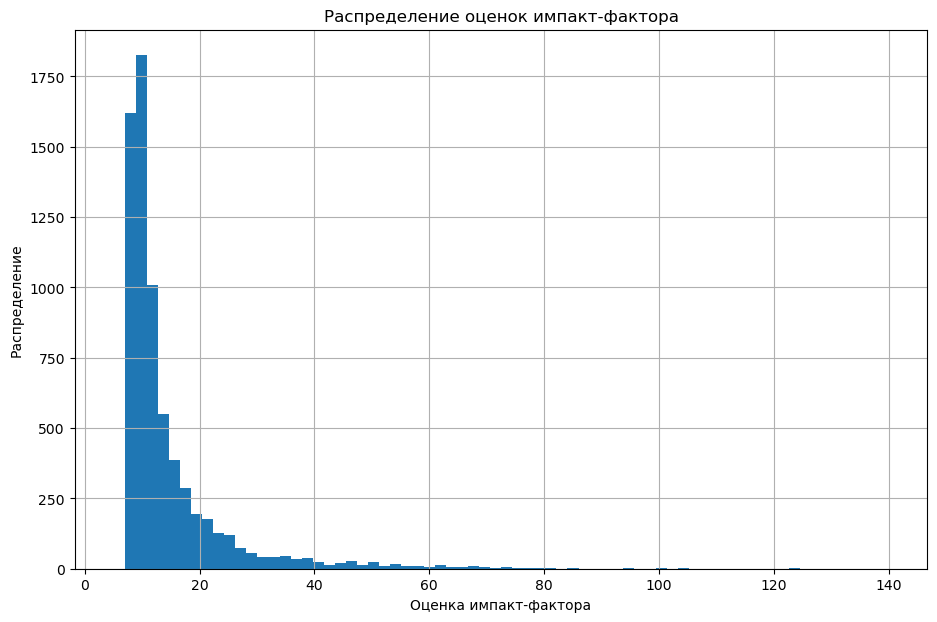

In [24]:
data.cite_score.hist(bins=70, figsize=(11, 7), range=(5, 140))

plt.title('Распределение оценок импакт-фактора')
plt.xlabel('Оценка импакт-фактора')
plt.ylabel('Распределение')

None #убирает лишнюю строчку над графиком

Чаще всего оценка варьируется от 5 до 10. 

In [25]:
#топ-15 категорий по кол-ву
data.category.value_counts().head(15)

General Medicine                                350
Cardiology and Cardiovascular Medicine          166
Oncology                                        144
Ecology, Evolution, Behavior and Systematics    135
Psychiatry and Mental Health                    121
Biochemistry                                    118
Plant Science                                   106
Neurology (clinical)                             99
Genetics                                         95
Computer Science Applications                    89
Pharmacology (medical)                           87
Infectious Diseases                              87
Immunology and Allergy                           84
Endocrinology, Diabetes and Metabolism           83
Space and Planetary Science                      82
Name: category, dtype: int64

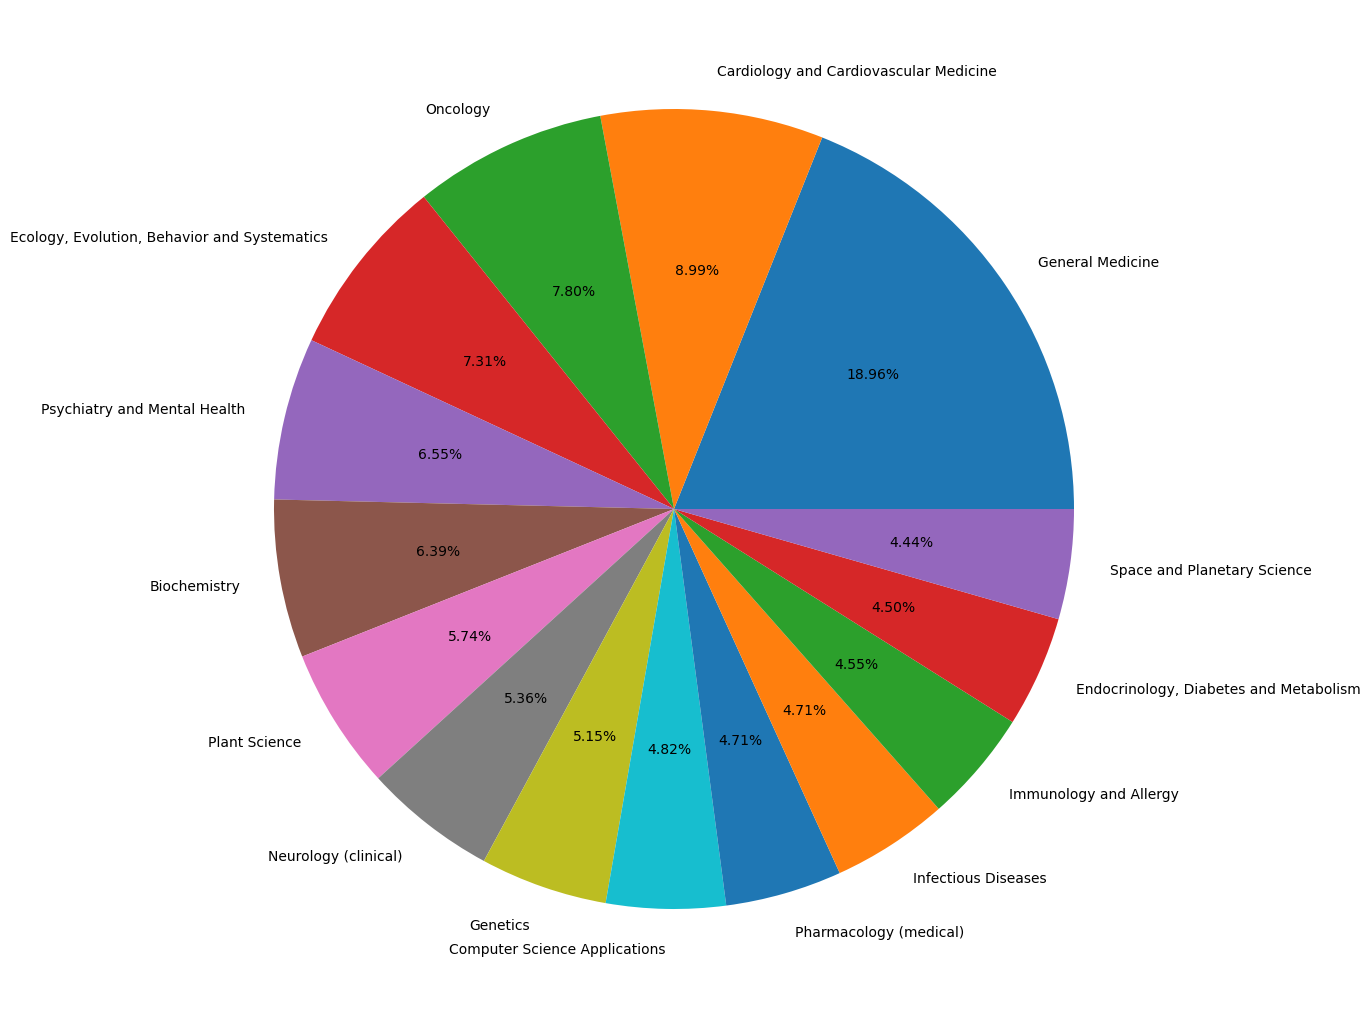

In [27]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
ax.pie(category_data['values'], labels = category_data['category'] ,autopct='%1.2f%%')
plt.show()

General Medicine - самый популярный категория

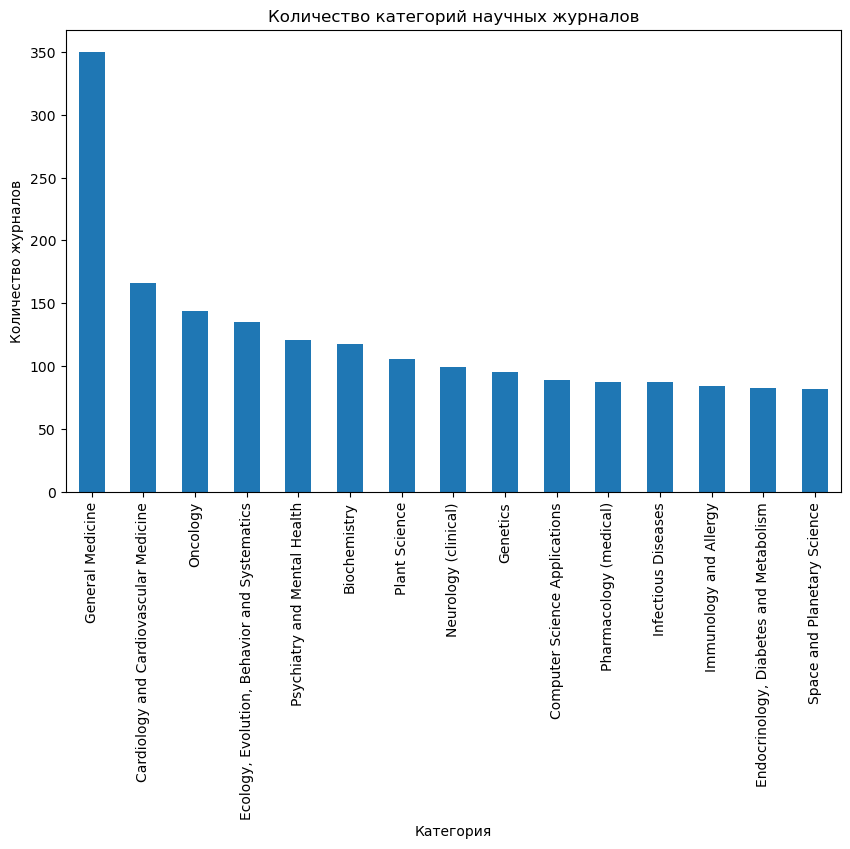

In [29]:
data.category.value_counts().head(15).plot.bar(figsize=(10,6))

plt.title('Количество категорий топ-15 журналов')
plt.xlabel('Категория')
plt.ylabel('Количество журналов')

None #убирает лишнюю строчку над графиком

In [30]:
#топ-15 издателей по кол-ву
data.publisher.value_counts().head(15)

Elsevier                        1900
Wiley-Blackwell                  969
Springer Nature                  873
IEEE                             318
Oxford University Press          287
Annual Reviews Inc.              246
Taylor & Francis                 222
Wolters Kluwer Health            190
SAGE                             168
American Chemical Society        165
Royal Society of Chemistry        90
BMJ Publishing Group              66
APA                               57
Cambridge University Press        56
American Medical Association      52
Name: publisher, dtype: int64

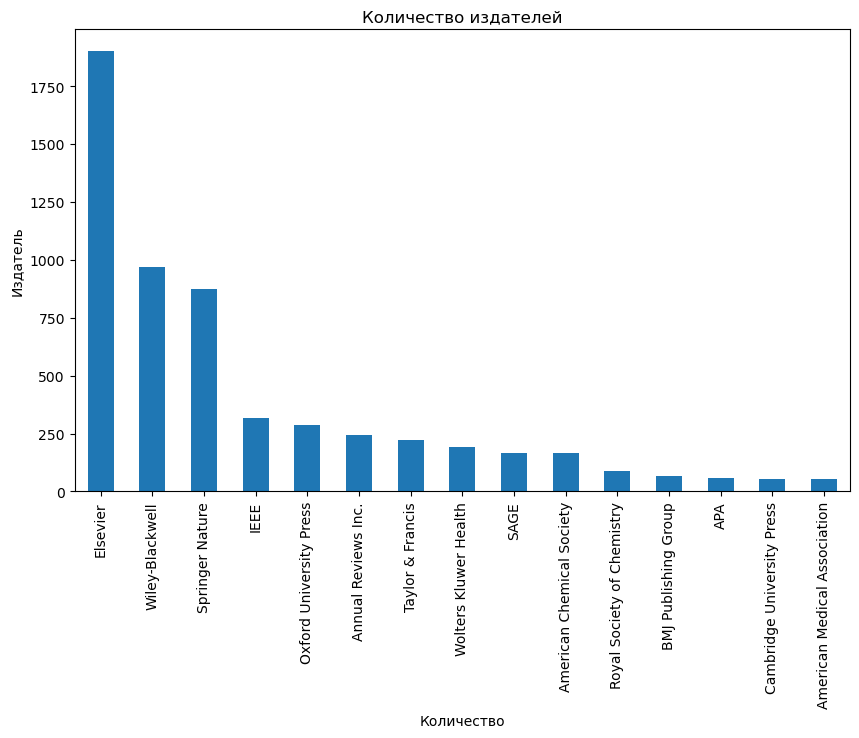

In [31]:
data.publisher.value_counts().head(15).plot.bar(figsize=(10,6))

plt.title('Количество издателей')
plt.xlabel('Количество')
plt.ylabel('Издатель')

None #убирает лишнюю строчку над графиком

Самый популярный издатель - Elsevier

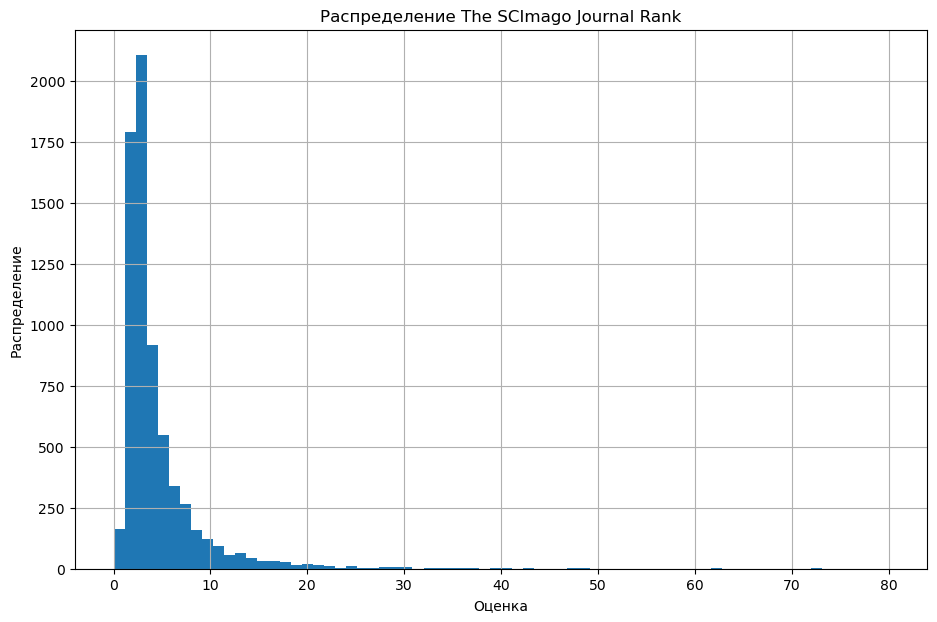

In [32]:
data.sjr.hist(bins=70, figsize=(11, 7), range=(0, 80))

plt.title('Распределение The SCImago Journal Rank')
plt.xlabel('Оценка')
plt.ylabel('Распределение')

None #убирает лишнюю строчку над графиком

Чаще всего sjr оценивается от 1 до 3.

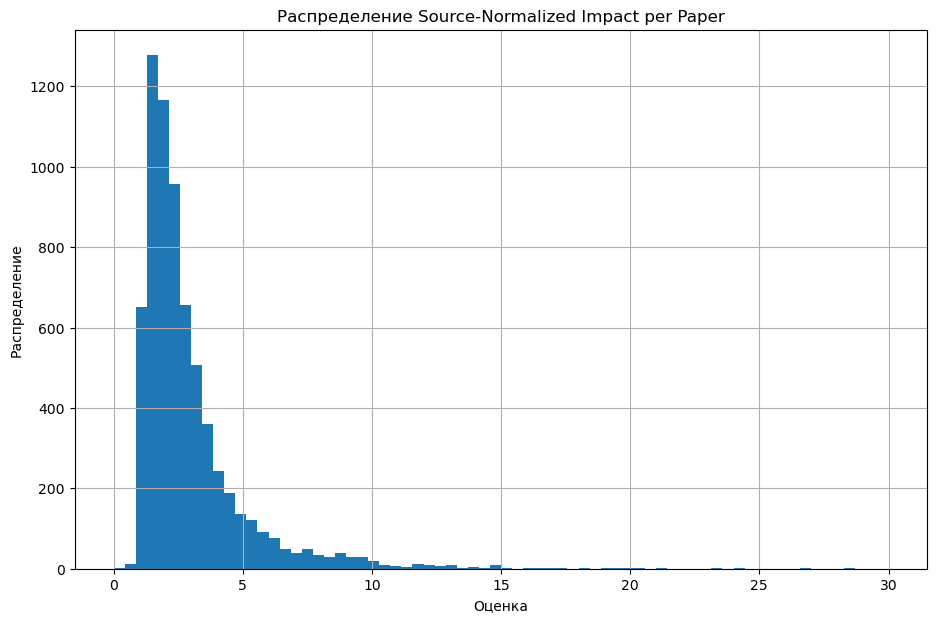

In [33]:
data.snip.hist(bins=70, figsize=(11, 7), range=(0, 30))

plt.title('Распределение Source-Normalized Impact per Paper')
plt.xlabel('Оценка')
plt.ylabel('Распределение')

None #убирает лишнюю строчку над графиком

Чаще всего snip оценивается от 1 до 2.

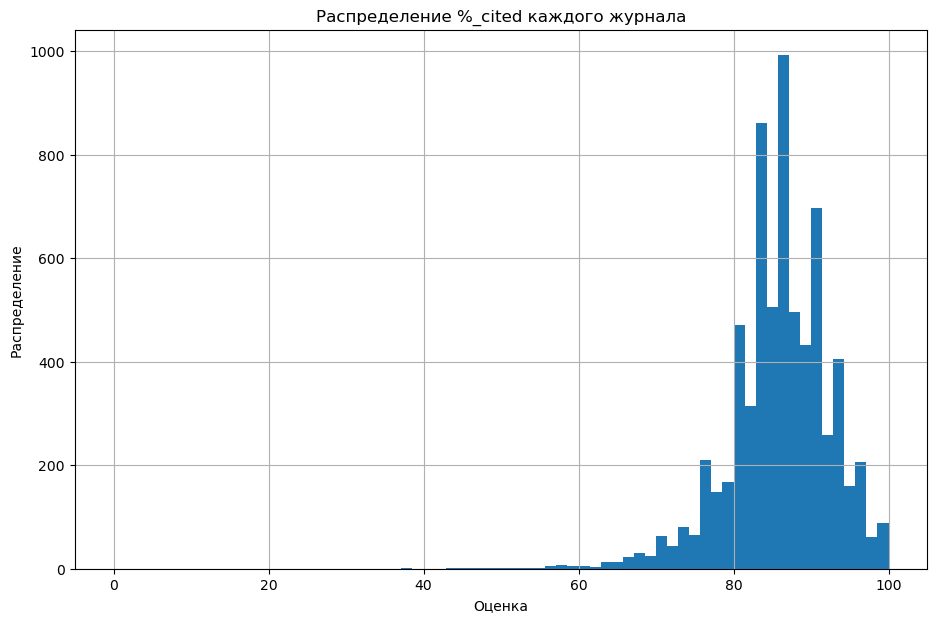

In [34]:
data['%_cited'].hist(bins=70, figsize=(11, 7), range=(0, 100))

plt.title('Распределение %_cited каждого журнала')
plt.xlabel('Оценка')
plt.ylabel('Распределение')

plt.show()
None #убирает лишнюю строчку над графиком

Чаще всего %_cited оценивается от 82 до 90.

Text(0.5, 1.0, 'Median_of_Cited')

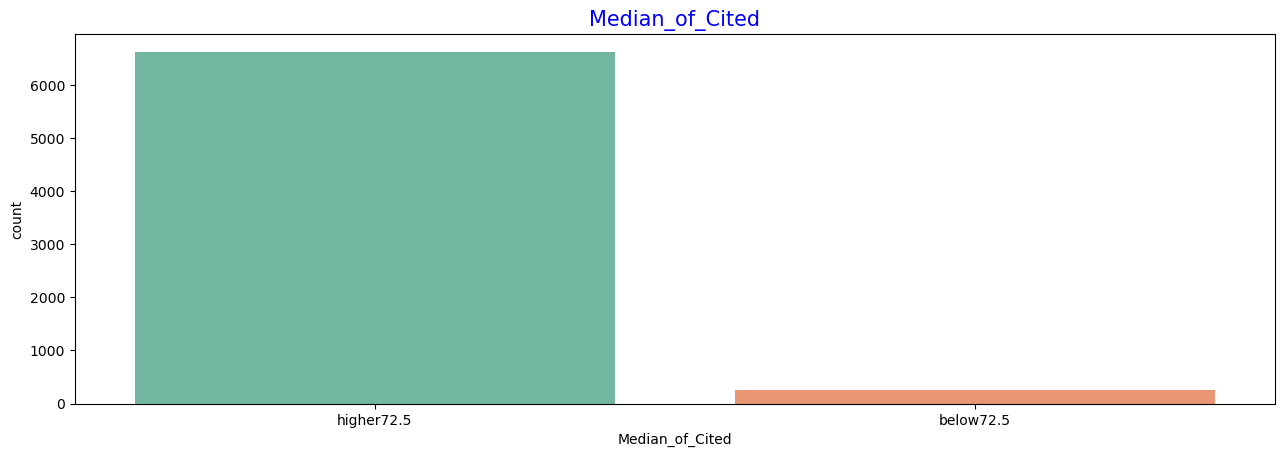

In [35]:
fig, axs =plt.subplots(ncols=1)
plt.subplots_adjust(right=2, wspace = 0.5)
sns.countplot(x=data['Median_of_Cited'],  palette="Set2")
axs.set_title('Median_of_Cited', color='blue', fontsize=15)

Наблюдается дисбаланс признака. Чаще всего журнал превышает медианное значение по проценту.

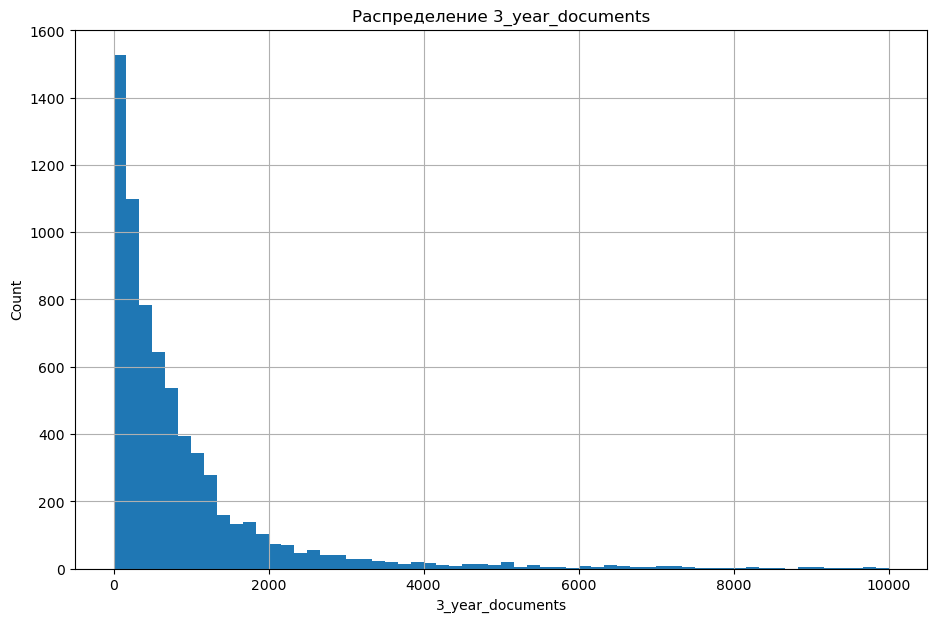

In [36]:
data['3_year_documents'].hist(bins=60, figsize=(11, 7), range=(0, 10000))

plt.title('Распределение 3_year_documents')
plt.xlabel('3_year_documents')
plt.ylabel('Count')

plt.show()
None #убирает лишнюю строчку над графиком

Чаще всего 3_year_documents оценивается от 0 до 150.

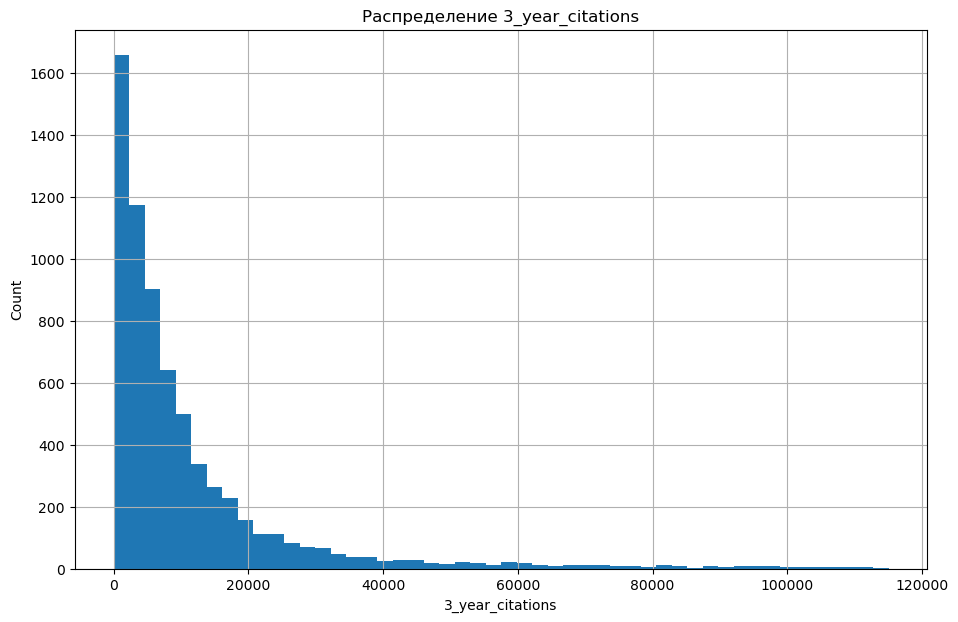

In [37]:
data['3_year_citations'].hist(bins=50, figsize=(11, 7), range=(0, 115000))

plt.title('Распределение 3_year_citations')
plt.xlabel('3_year_citations')
plt.ylabel('Count')

plt.show()
None #убирает лишнюю строчку над графиком

Чаще всего 3_year_citations оценивается от 0 до 1500.

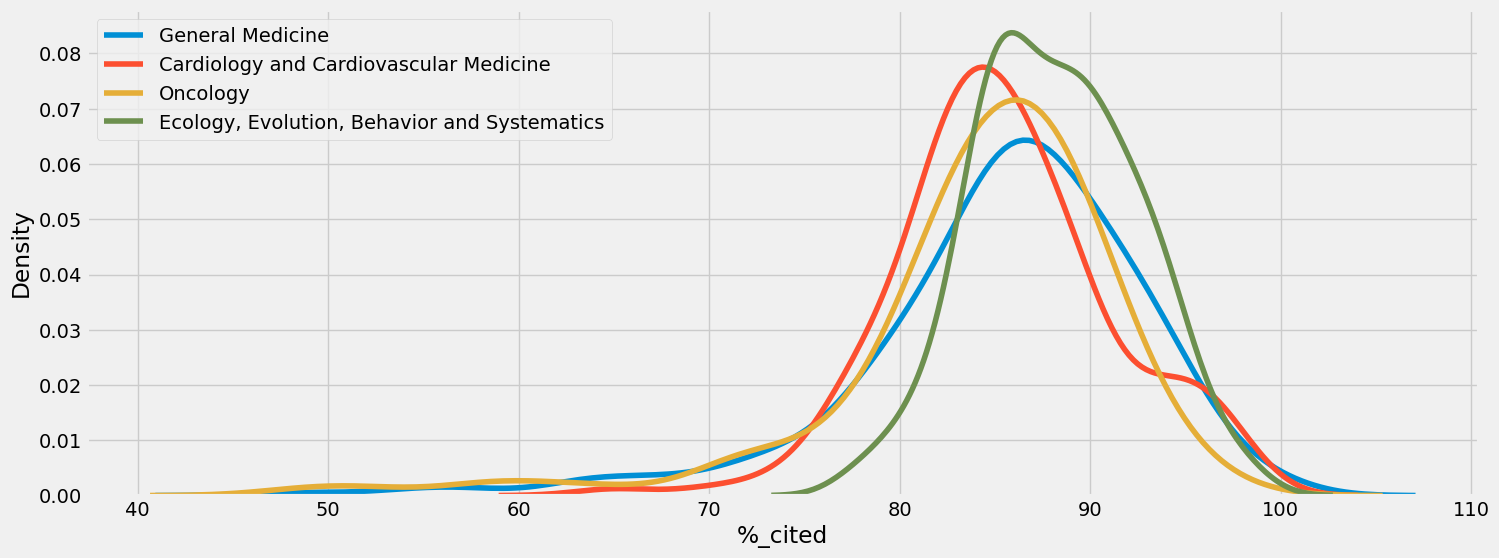

In [38]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(16, 6))
sns.kdeplot(data.loc[data['category'] == 'General Medicine', '%_cited'], label = 'General Medicine',shade=False)
sns.kdeplot(data.loc[data['category'] == 'Cardiology and Cardiovascular Medicine', '%_cited'], label = 'Cardiology and Cardiovascular Medicine',shade=False)
sns.kdeplot(data.loc[data['category'] == 'Oncology', '%_cited'], label = 'Oncology',shade=False)
sns.kdeplot(data.loc[data['category'] == 'Ecology, Evolution, Behavior and Systematics', '%_cited'], label = 'Ecology, Evolution, Behavior and Systematics',shade=False)
plt.legend(['General Medicine','Cardiology and Cardiovascular Medicine','Oncology','Ecology, Evolution, Behavior and Systematics'], loc=2)
plt.show()

Категория Ecology, Evolution, Behavior and Systematics имеет высокую плотность по %_cited.

Построим матрицу корреляция с помощью библиотеки phik.

In [39]:
interval_cols = ['cite_score','3_year_citations','3_year_documents','%_cited','snip','sjr','year']
data1 = data.drop(['highest_percentile'],axis=1)
phik_overview = data1.phik_matrix(interval_cols=interval_cols)

C:\Users\ASUS\anaconda3\lib\site-packages\phik\data_quality.py:59: UserWarning: The number of unique values of variable source_title is large: 1593. Are you sure this is not an interval variable? Analysis for pairs of variables including source_title can be slow.
  warnings.warn(


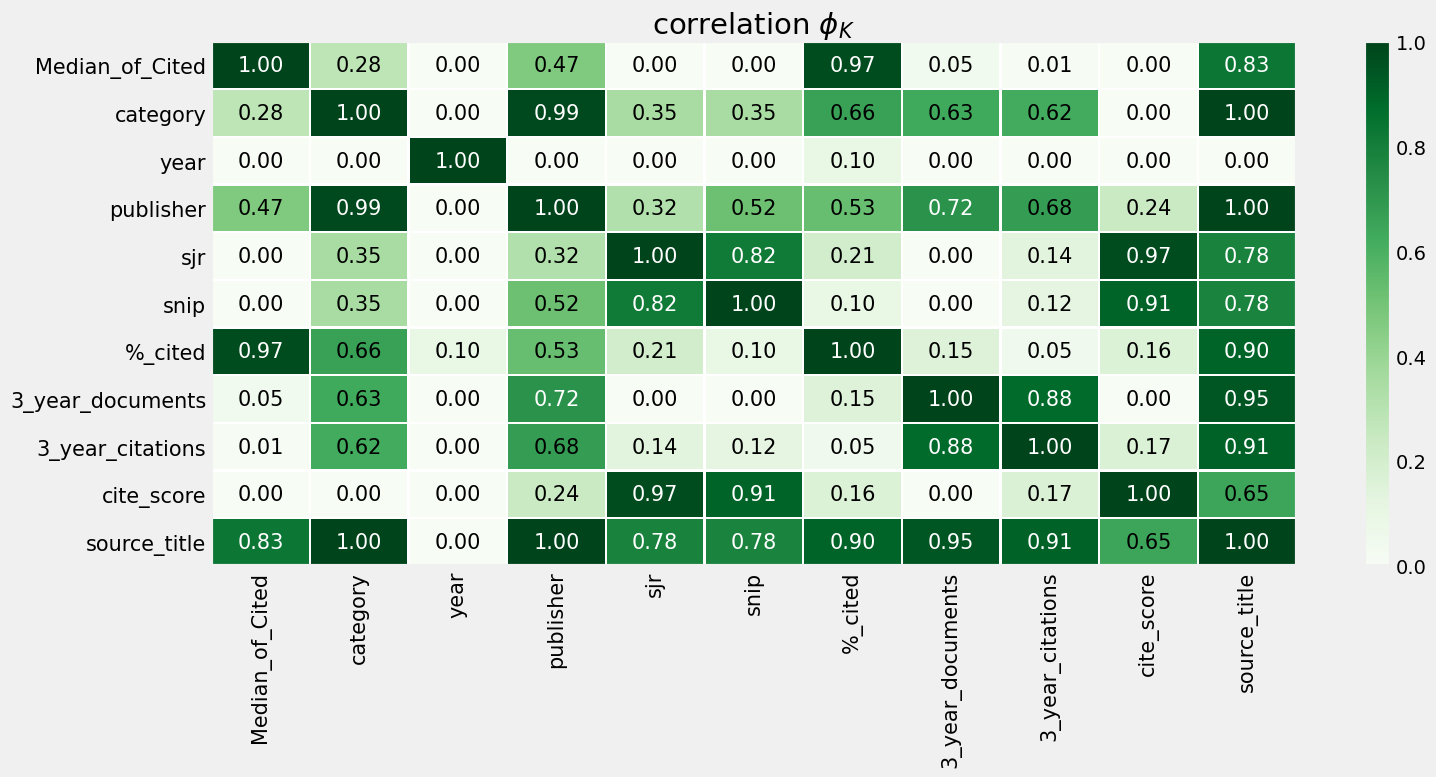

In [40]:
plot_correlation_matrix(phik_overview.values,
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index,
                        vmin=0, vmax=1, color_map="Greens", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(16, 8))
plt.tight_layout()

Мультиколинеарных признаков с 'cite_score' это 'sjr' и 'snip', которые является неинформативными признаками. Также в этот список нужно отнести 'source_title','highest_percentile'

## Построение моделей

In [41]:
data.head()

,source_title,cite_score,highest_percentile,3_year_citations,3_year_documents,%_cited,snip,sjr,publisher,year,category,Median_of_Cited
0,Ca-A Cancer Journal for Clinicians,435.4,99.0%\n1/331\nOncology,47455,109,94,113.744,88.192,Wiley-Blackwell,2019,Oncology,higher72.5
1,MMWR Recommendations and Reports,152.5,99.0%\n1/275\nHealth (social science),2288,15,87,37.543,41.022,Centers for Disease Control and Prevention (CDC),2019,Health (social science),higher72.5
2,Nature Reviews Materials,123.7,99.0%\n1/287\nMaterials Chemistry,23868,193,96,15.261,36.691,Springer Nature,2019,Materials Chemistry,higher72.5
3,Chemical Reviews,100.5,99.0%\n1/398\nGeneral Chemistry,97295,968,96,12.832,20.847,American Chemical Society,2019,General Chemistry,higher72.5
4,Reviews of Modern Physics,75.8,99.0%\n1/224\nGeneral Physics and Astronomy,11906,157,92,14.948,21.938,American Physical Society,2019,General Physics and Astronomy,higher72.5


In [42]:
#неинформативные признаки
delete=['source_title','highest_percentile','cite_score','snip','sjr']
#признаки
features=data.drop(delete,axis=1)
target = data['cite_score']
#разобьем данные на трейн и тест 75:25
features_train, features_test, target_train, target_test = train_test_split(features,target,test_size=0.25,random_state=130223)

### Масштабирование признаков

In [43]:
#численные признаки
numeric = ['3_year_citations','3_year_documents','%_cited']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

C:\Users\ASUS\AppData\Local\Temp\ipykernel_3708\2210667125.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
C:\Users\ASUS\AppData\Local\Temp\ipykernel_3708\2210667125.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])


### Порядковое кодирование

In [44]:
#категориальные признаки
category = data.columns.drop(delete+numeric)
category

Index(['publisher', 'category', 'Median_of_Cited'], dtype='object')

In [45]:
encoder = OrdinalEncoder(handle_unknown = 'игнорировать')
target_train=target_train.copy()
target_test=target_test.copy()
features_train=features_train.copy()
features_test=features_test.copy()
encoder.fit(features_train[category])
features_train[category] = encoder.transform(features_train[category])
features_test[category] = encoder.transform(features_test[category])

In [46]:
features_train

,3_year_citations,3_year_documents,%_cited,publisher,category,Median_of_Cited
6858,-0.497680,-0.517439,-3.327814,129.0,223.0,0.0
6061,1.575137,1.221683,0.786931,7.0,182.0,1.0
1278,-0.045624,-0.103114,0.177340,42.0,187.0,1.0
5645,-0.201211,0.008301,0.329738,26.0,81.0,1.0
5232,-0.335741,-0.345674,0.634533,146.0,113.0,1.0
...,...,...,...,...,...,...
2378,-0.489211,-0.537169,0.786931,146.0,230.0,1.0
3309,0.876487,1.149728,-0.432252,62.0,98.0,1.0
2024,-0.231050,-0.455348,1.244125,129.0,182.0,1.0
715,-0.252419,-0.186095,-0.127456,62.0,124.0,1.0


In [47]:
target_train

6858     7.2
6061    17.2
1278    14.7
5645     8.2
5232    11.9
        ... 
2378    11.9
3309    12.0
2024    32.4
715     10.2
572     11.4
Name: cite_score, Length: 5157, dtype: float64

### LinearRegression

In [48]:
state = 130223

In [89]:
model = LinearRegression()

In [92]:
#гиперпараметры
param_grid = [
    {'n_jobs' : range(-3,6)
    }
]
#подбор гиперпараметров
clf1 = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')

In [93]:
%%time
best_clf1 = clf1.fit(features_train,target_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 188 ms
Wall time: 4.24 s


In [52]:
best_clf1.best_score_

0.2783807398504593

In [53]:
best_clf1.best_estimator_

LinearRegression(n_jobs=-3)

In [54]:
best_clf1.best_params_

{'n_jobs': -3}

### LGBMRegressor

In [55]:
model = LGBMRegressor(class_weight='balanced',random_state=12345)

In [56]:
#гиперпараметры
param_grid = [
    {'n_estimators':range(100,1200,30),
     'max_depth':range(1,60,4),
    }
]
#подбор гиперпараметров
clf2 = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')

In [57]:
%%time
best_clf2 = clf2.fit(features_train,target_train)

Fitting 5 folds for each of 555 candidates, totalling 2775 fits
CPU times: total: 11 s
Wall time: 7min 1s


In [58]:
best_clf2.best_score_

0.9636477906791404

In [59]:
best_clf2.best_estimator_

LGBMRegressor(class_weight='balanced', max_depth=5, n_estimators=1180,
              random_state=12345)

In [60]:
best_clf2.best_params_

{'max_depth': 5, 'n_estimators': 1180}

### CatBoostRegressor

In [61]:
catboost = CatBoostRegressor(random_state=12345,iterations=250,learning_rate=0.5)
#гиперпараметры
param_grid = [
    {'max_depth':range(1,10)}]

In [62]:
#подбор гиперпараметров
clf3 = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')

In [63]:
%%time
best_clf3=clf3.fit(features_train,target_train)
best_clf3.best_score_

Fitting 5 folds for each of 9 candidates, totalling 45 fits
CPU times: total: 125 ms
Wall time: 527 ms


0.9455962706420147

In [64]:
best_clf3.best_params_

{'max_depth': 4}

### LassoCV

In [66]:
model = LassoCV()
#model.fit(features_train,target_train)
#predicted = model.predict(features_test)

In [67]:
#гиперпараметры
param_grid = [
    {'n_jobs' : range(-3,4),
     'max_iter':range(100,1200,100),
     'n_alphas':range(100,1200,100)
    }
]
#для выполнения k-кратной перекрестной проверки. Повторим перекрестную проверку 1 раз
cv = RepeatedKFold(n_splits= 3,n_repeats= 1, random_state= 1 )
#подбор гиперпараметров
clf4 = GridSearchCV(model, param_grid = param_grid, cv = cv, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')


None

In [68]:
%%time
import warnings#чтобы не было предупреждения
warnings.filterwarnings('ignore')
best_clf4=clf4.fit(features_train,target_train)
best_clf4.best_score_

Fitting 3 folds for each of 847 candidates, totalling 2541 fits
CPU times: total: 5.14 s
Wall time: 2min 41s


0.24908214257462635

In [69]:
best_clf4.best_params_

{'max_iter': 100, 'n_alphas': 100, 'n_jobs': -3}

### Ridge

In [70]:
model = Ridge(random_state=12345)

In [71]:
#гиперпараметры
param_grid = [
    {'max_iter':range(100,2000,100)
    }
]
#подбор гиперпараметров
clf5 = GridSearchCV(model, param_grid = param_grid, cv = 5, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')

In [72]:
%%time
best_clf5=clf5.fit(features_train,target_train)
best_clf5.best_score_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
CPU times: total: 31.2 ms
Wall time: 194 ms


0.27842602890522794

In [73]:
best_clf5.best_params_

{'max_iter': 100}

### ElasticNetCV

In [74]:
model = ElasticNetCV()

In [75]:
#гиперпараметры
param_grid = [
    {'n_jobs' : range(-3,4),
     'max_iter':range(100,1200,100),
     'n_alphas':range(100,1200,100)
    }
]
#подбор гиперпараметров
clf6 = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')

In [76]:
%%time
import warnings#чтобы не было предупреждения
warnings.filterwarnings('ignore')
best_clf6=clf6.fit(features_train,target_train)
best_clf6.best_score_

Fitting 3 folds for each of 847 candidates, totalling 2541 fits
CPU times: total: 7.58 s
Wall time: 2min 42s


0.26665207149838993

In [77]:
best_clf6.best_params_

{'max_iter': 100, 'n_alphas': 100, 'n_jobs': -3}

### KNeighborsRegressor

In [78]:
model = KNeighborsRegressor()

In [79]:
#гиперпараметры
param_grid = [
    {'n_neighbors':range(1,16,2),
     'leaf_size':range(10,60,10)
    }
]
#подбор гиперпараметров
clf7 = GridSearchCV(model, param_grid = param_grid, cv = 3, verbose = True, n_jobs=-2,scoring = ['r2','neg_mean_squared_error'],refit = 'r2')


In [80]:
best_clf7=clf7.fit(features_train,target_train)
best_clf7.best_score_

Fitting 3 folds for each of 40 candidates, totalling 120 fits


0.5811699070207735

In [81]:
best_clf7.best_params_

{'leaf_size': 10, 'n_neighbors': 1}

### Определение лучшей модели

In [82]:
results = [best_clf1.best_score_,best_clf2.best_score_,best_clf3.best_score_,
           best_clf4.best_score_,best_clf5.best_score_,best_clf6.best_score_,best_clf7.best_score_]
index = ['LinearRegression','LGBMRegressor','CatBoostRegressor','LassoCV','Ridge','ElasticNetCV','KNeighborsRegressor']

best_result = pd.DataFrame(results,index=index,columns=['best_score']).sort_values(by='best_score',ascending=False)
best_result

,best_score
LGBMRegressor,0.963648
CatBoostRegressor,0.945596
KNeighborsRegressor,0.581170
Ridge,0.278426
LinearRegression,0.278381
ElasticNetCV,0.266652
LassoCV,0.249082


### Финальный тест

In [83]:
predictions = best_clf2.predict(features_test)
print(r2_score(target_test,predictions))

0.8436586539162089


In [84]:
print(mean_squared_error(target_test,predictions))

20.01702248539423


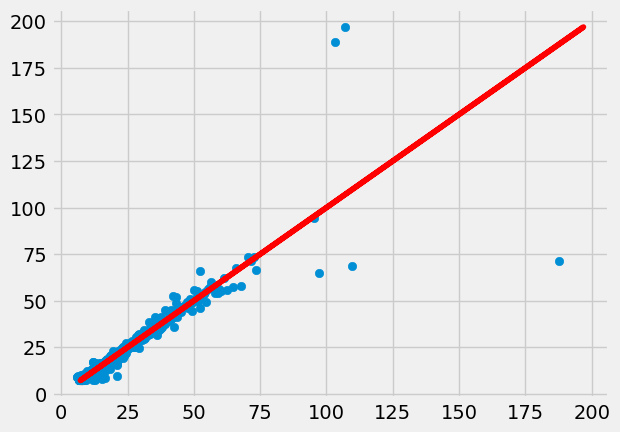

In [85]:
#связь между реальными и предсказанными значениями целевой переменной
plt.scatter(predictions, target_test)
plt.plot(target_test, target_test, c='r')

### Анализ важности признаков

In [86]:
model = LGBMRegressor(class_weight='balanced', max_depth=5, n_estimators=1180, random_state=12345)

In [87]:
model.fit(features_train,target_train)

LGBMRegressor(class_weight='balanced', max_depth=5, n_estimators=1180,
              random_state=12345)

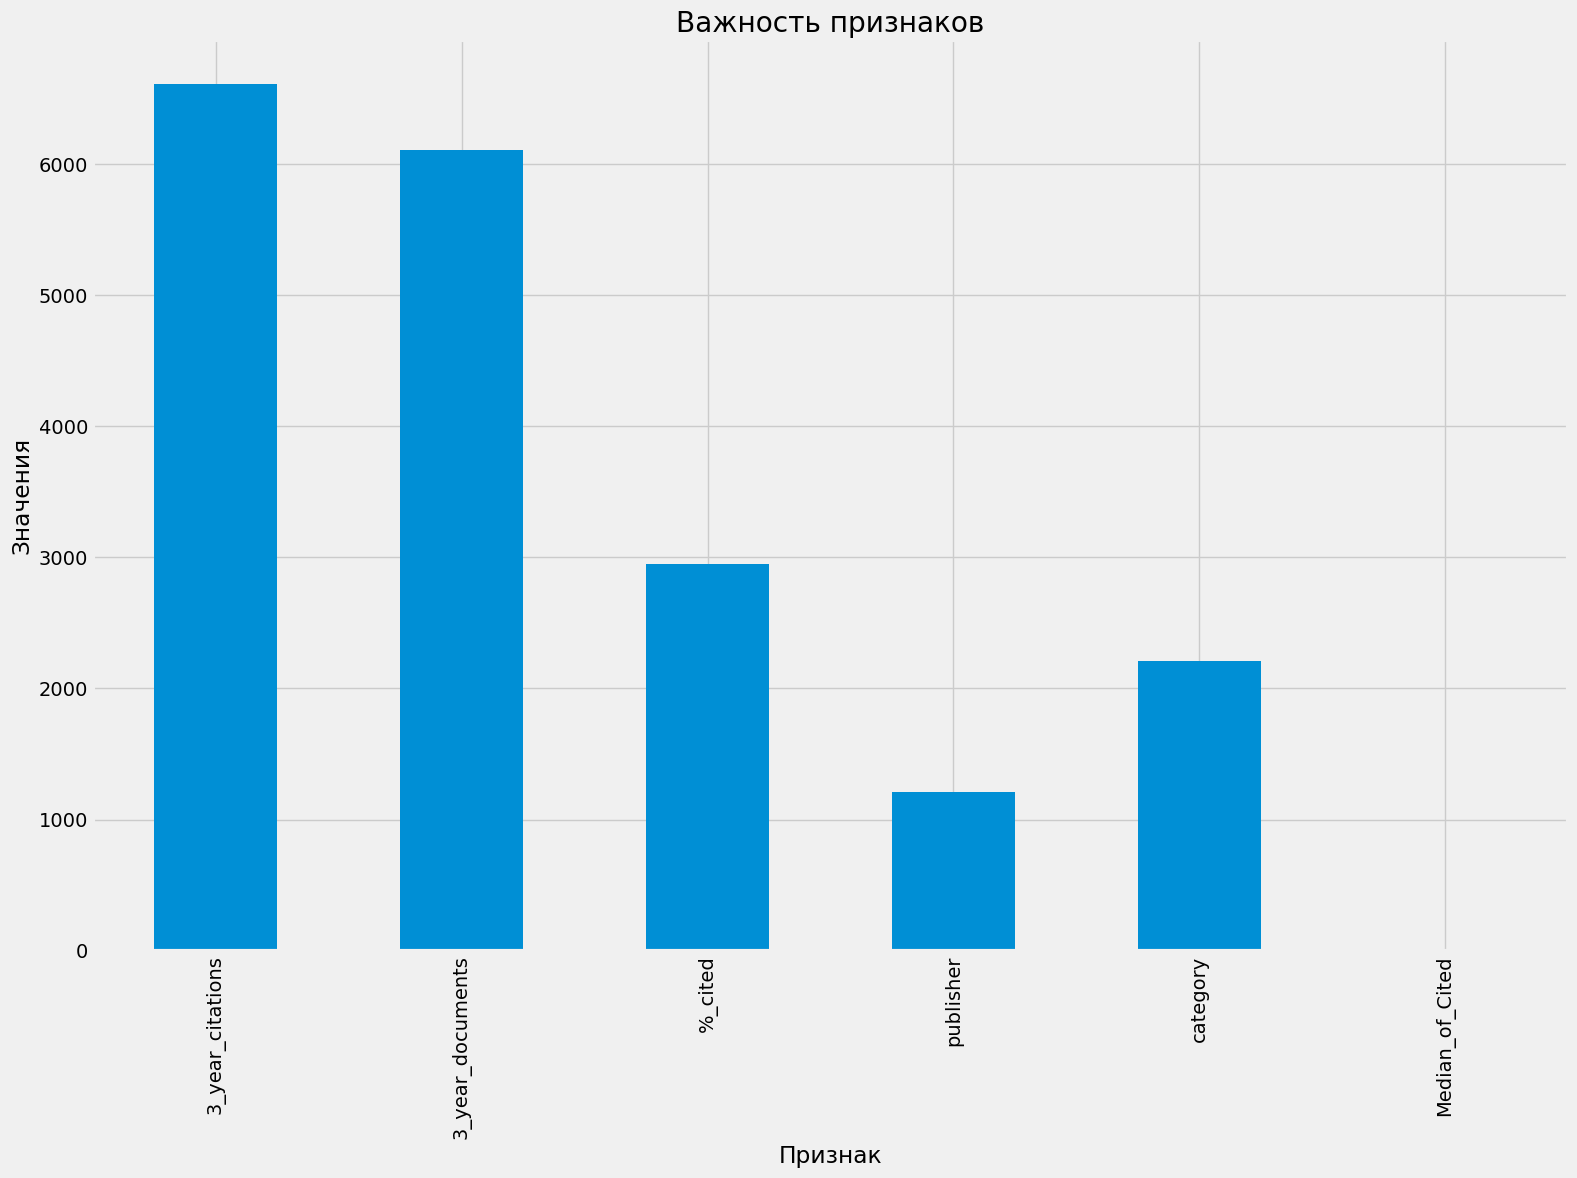

In [88]:
cat_iris_imp = pd.Series(model.feature_importances_,
                         data.drop(delete, axis=1).columns)
fig, ax = plt.subplots(figsize=(16,12))
cat_iris_imp.plot.bar(ax=ax)
ax.set_title("Важность признаков")
ax.set_ylabel('Значения')
ax.set_xlabel('Признак')
fig.tight_layout()
None